### Preparation

In [ ]:
# Import libraries needed
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount the Google Drive to get the datasets uploaded
# If not using Google Drive, please change the file path under cells of Dataset
# e.g. Dataset 1: breast cancer
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Function: get tensor from npz file

In [ ]:
def get_tensor(path):
    data = np.load(path)
    train_X = torch.from_numpy(data['train_X']).float()
    train_Y = torch.from_numpy(data['train_Y']).long()
    test_X = torch.from_numpy(data['test_X']).float()
    test_Y = torch.from_numpy(data['test_Y']).long()
    return train_X, train_Y, test_X, test_Y

### Function: create datasets by SubsetRandomSampler and DataLoader

In [ ]:
# Create training, validation and testing dataset by SubsetRandomSampler and DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as Data

def create_datasets(batch_size, train_X, train_Y, test_X, test_Y):
    # Percentage of training set to use as validation
    valid_size = 0.2

    # Transform Tensors to TensorDataset
    train_data = Data.TensorDataset(train_X, train_Y)
    test_data = Data.TensorDataset(test_X, test_Y)
    
    # Slice data randomly for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # Define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Load training, validation and testing data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, valid_loader, test_loader

### Class: network

In [ ]:
class Net_binary(nn.Module):

    def __init__(self, n_features, hidden_units, output = 2):
        super(Net_binary, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 1)
        return x

### Function: train the model

In [ ]:
def train_model(model, n_epochs, es_thres, patience):
    # Track the losses during trainings
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 

    # Track the losses during trainings
    train_acc = []
    valid_acc = []
    avg_train_acc = []
    avg_valid_acc = [] 

    # Set up counter for early stopping
    es_counter = 0
    
    for epoch in range(1, n_epochs + 1):
        # Train the model
        model.train()
        for X, Y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            # Record training loss & accuracy
            train_losses.append(loss.item())
            acc = 100 * torch.sum(Y==torch.max(output.data, 1)[1]).double() / len(Y)
            train_acc.append(acc.item())
 
        # Validate the model
        model.eval()
        for X, Y in valid_loader:
            output = model(X)
            loss = criterion(output, Y)
            # record validation loss & accuracy
            valid_losses.append(loss.item())
            acc = 100 * torch.sum(Y==torch.max(output.data, 1)[1]).double() / len(Y)
            valid_acc.append(acc.item())
 
        # Calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        # Calculate average accuracy over an epoch
        train_acc = np.average(train_acc)
        valid_acc = np.average(valid_acc)
        avg_train_acc.append(train_acc)
        avg_valid_acc.append(valid_acc)

        # Format the printing message for tracking training progress
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}]', 
                     f'train_loss: {train_loss:.5f}',
                     f'valid_loss: {valid_loss:.5f}',
                     f'train_acc: {train_acc:.5f}',
                     f'valid_acc: {valid_acc:.5f}')
        print(print_msg)
        
        # Set up early stopping
        if epoch > 1:
            if ((avg_train_losses[-2] - avg_train_losses[-1]) < es_thres and (avg_valid_losses[-2] - avg_valid_losses[-1]) < es_thres) or \
               (train_acc == valid_acc == 100):
                es_counter += 1
            if es_counter >= patience:
                print("Early stopping")
                break

        # Clear lists to track next epoch
        train_losses = []
        valid_losses = []
        train_acc = []
        valid_acc = []

    return model, avg_train_acc[-1]

### Function: test the model

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sn

def test_model(model):
    test_acc = []
    prob_all = []
    label_all = []
    y_pred_all = []

    # Test the model
    model.eval()
    for X, Y in test_loader:
        output = model(X)
        y_pred = torch.max(output.data, 1)[1]
        acc = 100 * torch.sum(Y==y_pred).double() / len(Y)
        test_acc.append(acc.item())
        prob_all.extend(output[:,1])
        label_all.extend(Y)
        y_pred_all.extend(y_pred.numpy())

    # Obtain the testing accuracy and AUC
    test_acc = np.average(test_acc)
    test_AUC = roc_auc_score(label_all,prob_all)

    # Clarify constant for classes
    classes = ('0', '1')

    # Build confusion matrix
    cf_matrix = confusion_matrix(label_all, y_pred_all)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix),
                         index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

    # Get classification report
    acc_score = accuracy_score(label_all, y_pred_all)
    report = classification_report(label_all, y_pred_all,target_names = classes)
    print(report)

    return net, test_acc, test_AUC, df_cm, acc_score, report

### Function: plot the accuracy with different number of hidden units

In [ ]:
import matplotlib.pyplot as plt

def plot_hidden_units(myDict, title):
    myList = myDict.items()
    myList = sorted(myList)
    x, y = zip(*myList)
    plt.plot(x, y)
    plt.ylim(0, 100)
    plt.xlabel('No. of hidden units')
    plt.ylabel('Accuracy %')
    plt.title(title)
    plt.show()

### Set up of experiment in datasets

In [ ]:
H = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dict_features = {'breast-cancer': 10, 'diabetes': 8, 'iris': 4, 'wine': 13}

### Dataset 1: breast-cancer

In [ ]:
data1 = 'breast-cancer'
train_X, train_Y, test_X, test_Y = get_tensor(f'/content/drive/My Drive/HKUST/MSBD5002/datasets/bi-class/{data1}.npz')
n_features = dict_features[data1]

# Create empty dictionaries for storing data
bc_train_acc = {}
bc_test_acc = {}
bc_test_AUC = {}
bc_time = {}
bc_acc_score = {}

In [ ]:
# Hyperparameters from training
batch_size = 20
n_epochs = 200
patience = 5
es_thres = 0.00001

# Create datasets by batches
train_loader, valid_loader, test_loader = create_datasets(batch_size, train_X, train_Y, test_X, test_Y)

******************** Hidden Unit 1 ********************
('[  1/200]', 'train_loss: 0.71824', 'valid_loss: 0.71659', 'train_acc: 34.97475', 'valid_acc: 34.72222')
('[  2/200]', 'train_loss: 0.71370', 'valid_loss: 0.71094', 'train_acc: 34.84848', 'valid_acc: 35.74074')
('[  3/200]', 'train_loss: 0.70923', 'valid_loss: 0.70668', 'train_acc: 34.92424', 'valid_acc: 35.74074')
('[  4/200]', 'train_loss: 0.70522', 'valid_loss: 0.70243', 'train_acc: 34.94949', 'valid_acc: 36.75926')
('[  5/200]', 'train_loss: 0.70159', 'valid_loss: 0.70082', 'train_acc: 34.89899', 'valid_acc: 33.70370')
('[  6/200]', 'train_loss: 0.69819', 'valid_loss: 0.69707', 'train_acc: 34.94949', 'valid_acc: 34.72222')
('[  7/200]', 'train_loss: 0.69509', 'valid_loss: 0.69411', 'train_acc: 34.94949', 'valid_acc: 34.72222')
('[  8/200]', 'train_loss: 0.69220', 'valid_loss: 0.69145', 'train_acc: 44.89899', 'valid_acc: 73.24074')
('[  9/200]', 'train_loss: 0.68952', 'valid_loss: 0.68842', 'train_acc: 78.33333', 'valid_acc: 7

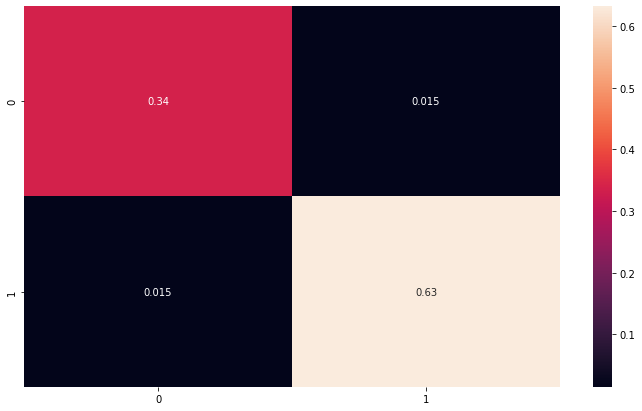

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      0.98      0.98        88

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136

---------- Accuracy of testing in Hidden Unit 1: 97.14285714285714%---------- 
******************** Hidden Unit 2 ********************
('[  1/200]', 'train_loss: 0.64817', 'valid_loss: 0.64539', 'train_acc: 65.02525', 'valid_acc: 65.27778')
('[  2/200]', 'train_loss: 0.64554', 'valid_loss: 0.65076', 'train_acc: 65.05051', 'valid_acc: 63.24074')
('[  3/200]', 'train_loss: 0.64279', 'valid_loss: 0.63773', 'train_acc: 65.12626', 'valid_acc: 66.29630')
('[  4/200]', 'train_loss: 0.64072', 'valid_loss: 0.63504', 'train_acc: 65.00000', 'valid_acc: 66.29630')
('[  5/200]', 'train_loss: 0.63776', 'valid_loss: 0.63644', 'train_acc: 65.10101', 'valid_acc: 65.27778')
('[  6/2

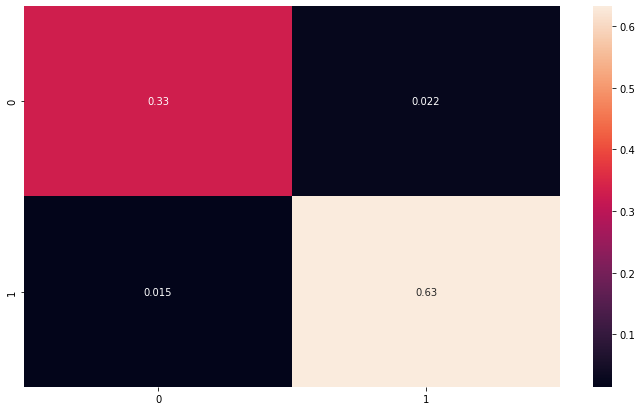

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        48
           1       0.97      0.98      0.97        88

    accuracy                           0.96       136
   macro avg       0.96      0.96      0.96       136
weighted avg       0.96      0.96      0.96       136

---------- Accuracy of testing in Hidden Unit 2: 96.25%---------- 
******************** Hidden Unit 3 ********************
('[  1/200]', 'train_loss: 0.76479', 'valid_loss: 0.74725', 'train_acc: 34.94949', 'valid_acc: 33.88889')
('[  2/200]', 'train_loss: 0.73145', 'valid_loss: 0.71725', 'train_acc: 34.89899', 'valid_acc: 31.85185')
('[  3/200]', 'train_loss: 0.69348', 'valid_loss: 0.66846', 'train_acc: 35.15152', 'valid_acc: 35.92593')
('[  4/200]', 'train_loss: 0.65260', 'valid_loss: 0.63303', 'train_acc: 61.33838', 'valid_acc: 90.27778')
('[  5/200]', 'train_loss: 0.61169', 'valid_loss: 0.58857', 'train_acc: 93.63636', 'valid_acc: 98.33333')
('[  6/200]', 'train

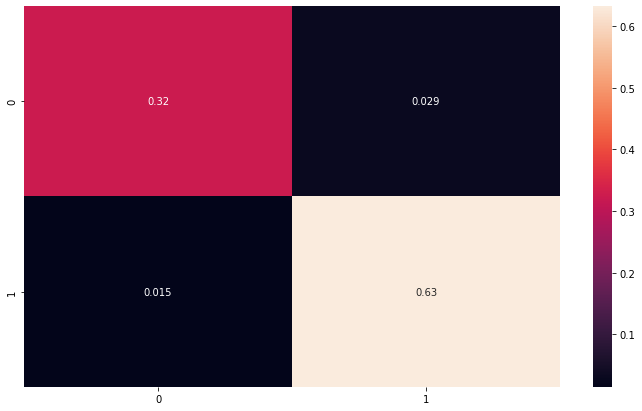

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.96      0.98      0.97        88

    accuracy                           0.96       136
   macro avg       0.96      0.95      0.95       136
weighted avg       0.96      0.96      0.96       136

---------- Accuracy of testing in Hidden Unit 3: 95.53571428571429%---------- 
******************** Hidden Unit 4 ********************
('[  1/200]', 'train_loss: 0.66043', 'valid_loss: 0.66820', 'train_acc: 65.02525', 'valid_acc: 61.20370')
('[  2/200]', 'train_loss: 0.65637', 'valid_loss: 0.64899', 'train_acc: 64.97475', 'valid_acc: 66.29630')
('[  3/200]', 'train_loss: 0.65151', 'valid_loss: 0.64785', 'train_acc: 65.10101', 'valid_acc: 65.27778')
('[  4/200]', 'train_loss: 0.64682', 'valid_loss: 0.64258', 'train_acc: 65.05051', 'valid_acc: 65.27778')
('[  5/200]', 'train_loss: 0.64093', 'valid_loss: 0.63615', 'train_acc: 65.10101', 'valid_acc: 65.27778')
('[  6/2

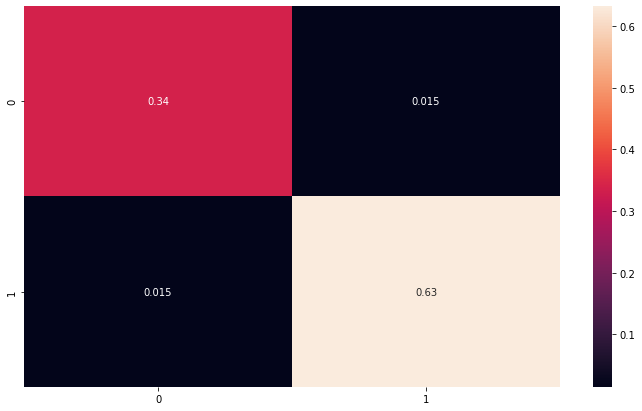

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      0.98      0.98        88

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136

---------- Accuracy of testing in Hidden Unit 4: 97.14285714285714%---------- 
******************** Hidden Unit 5 ********************
('[  1/200]', 'train_loss: 0.64893', 'valid_loss: 0.64625', 'train_acc: 65.12626', 'valid_acc: 64.25926')
('[  2/200]', 'train_loss: 0.63836', 'valid_loss: 0.63001', 'train_acc: 65.10101', 'valid_acc: 66.29630')
('[  3/200]', 'train_loss: 0.62788', 'valid_loss: 0.61903', 'train_acc: 65.10101', 'valid_acc: 66.29630')
('[  4/200]', 'train_loss: 0.61767', 'valid_loss: 0.62133', 'train_acc: 65.07576', 'valid_acc: 62.22222')
('[  5/200]', 'train_loss: 0.60756', 'valid_loss: 0.60147', 'train_acc: 65.12626', 'valid_acc: 65.27778')
('[  6/2

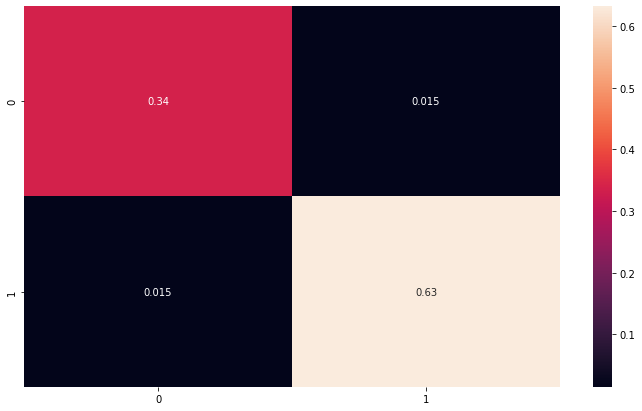

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      0.98      0.98        88

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136

---------- Accuracy of testing in Hidden Unit 5: 97.14285714285714%---------- 
******************** Hidden Unit 6 ********************
('[  1/200]', 'train_loss: 0.64601', 'valid_loss: 0.64392', 'train_acc: 75.32828', 'valid_acc: 76.11111')
('[  2/200]', 'train_loss: 0.63841', 'valid_loss: 0.63287', 'train_acc: 75.80808', 'valid_acc: 78.14815')
('[  3/200]', 'train_loss: 0.63042', 'valid_loss: 0.62540', 'train_acc: 76.23737', 'valid_acc: 77.12963')
('[  4/200]', 'train_loss: 0.62185', 'valid_loss: 0.61470', 'train_acc: 76.64141', 'valid_acc: 78.14815')
('[  5/200]', 'train_loss: 0.61232', 'valid_loss: 0.60674', 'train_acc: 76.96970', 'valid_acc: 77.12963')
('[  6/2

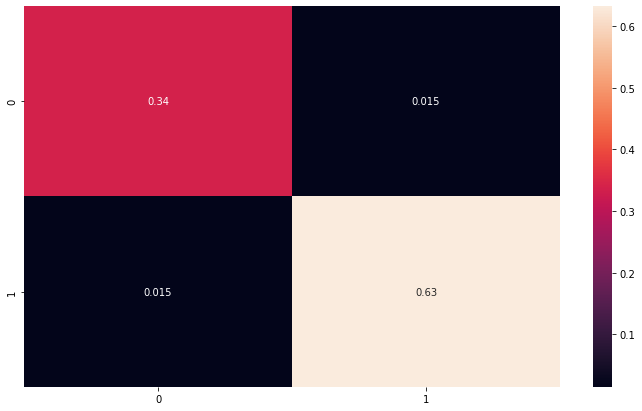

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      0.98      0.98        88

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136

---------- Accuracy of testing in Hidden Unit 6: 97.14285714285714%---------- 
******************** Hidden Unit 7 ********************
('[  1/200]', 'train_loss: 0.71710', 'valid_loss: 0.70994', 'train_acc: 27.12121', 'valid_acc: 32.40741')
('[  2/200]', 'train_loss: 0.70890', 'valid_loss: 0.70337', 'train_acc: 27.85354', 'valid_acc: 29.72222')
('[  3/200]', 'train_loss: 0.70093', 'valid_loss: 0.69560', 'train_acc: 28.81313', 'valid_acc: 30.37037')
('[  4/200]', 'train_loss: 0.68946', 'valid_loss: 0.68218', 'train_acc: 57.85354', 'valid_acc: 79.44444')
('[  5/200]', 'train_loss: 0.67529', 'valid_loss: 0.66664', 'train_acc: 83.78788', 'valid_acc: 85.64815')
('[  6/2

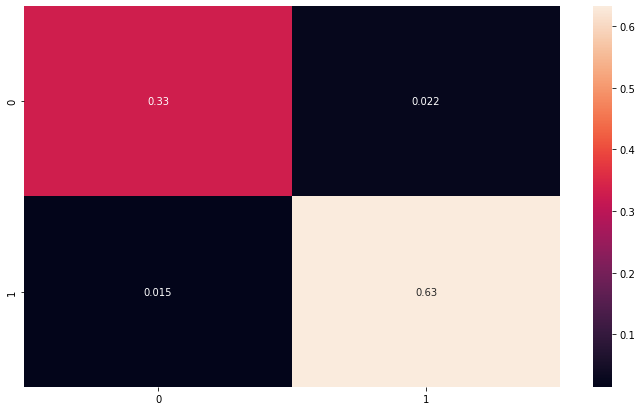

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        48
           1       0.97      0.98      0.97        88

    accuracy                           0.96       136
   macro avg       0.96      0.96      0.96       136
weighted avg       0.96      0.96      0.96       136

---------- Accuracy of testing in Hidden Unit 7: 96.25%---------- 
******************** Hidden Unit 8 ********************
('[  1/200]', 'train_loss: 0.72653', 'valid_loss: 0.70915', 'train_acc: 33.58586', 'valid_acc: 32.87037')
('[  2/200]', 'train_loss: 0.69689', 'valid_loss: 0.68413', 'train_acc: 33.30808', 'valid_acc: 32.68519')
('[  3/200]', 'train_loss: 0.67388', 'valid_loss: 0.65955', 'train_acc: 57.44949', 'valid_acc: 97.50000')
('[  4/200]', 'train_loss: 0.65298', 'valid_loss: 0.63839', 'train_acc: 93.13131', 'valid_acc: 97.50000')
('[  5/200]', 'train_loss: 0.63264', 'valid_loss: 0.61927', 'train_acc: 94.09091', 'valid_acc: 95.64815')
('[  6/200]', 'train

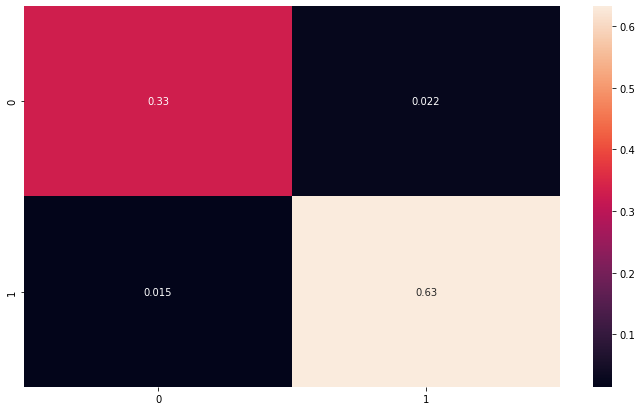

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        48
           1       0.97      0.98      0.97        88

    accuracy                           0.96       136
   macro avg       0.96      0.96      0.96       136
weighted avg       0.96      0.96      0.96       136

---------- Accuracy of testing in Hidden Unit 8: 96.25%---------- 
******************** Hidden Unit 9 ********************
('[  1/200]', 'train_loss: 0.69355', 'valid_loss: 0.68509', 'train_acc: 65.50505', 'valid_acc: 66.29630')
('[  2/200]', 'train_loss: 0.68046', 'valid_loss: 0.68013', 'train_acc: 65.73232', 'valid_acc: 63.24074')
('[  3/200]', 'train_loss: 0.66823', 'valid_loss: 0.66560', 'train_acc: 65.98485', 'valid_acc: 64.25926')
('[  4/200]', 'train_loss: 0.65670', 'valid_loss: 0.65564', 'train_acc: 66.46465', 'valid_acc: 64.25926')
('[  5/200]', 'train_loss: 0.64651', 'valid_loss: 0.63799', 'train_acc: 66.33838', 'valid_acc: 66.29630')
('[  6/200]', 'train

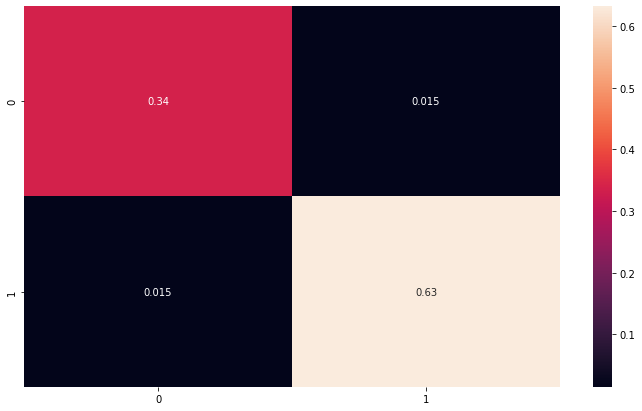

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      0.98      0.98        88

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136

---------- Accuracy of testing in Hidden Unit 9: 97.14285714285714%---------- 
******************** Hidden Unit 10 ********************
('[  1/200]', 'train_loss: 0.68399', 'valid_loss: 0.68068', 'train_acc: 69.69697', 'valid_acc: 67.12963')
('[  2/200]', 'train_loss: 0.67848', 'valid_loss: 0.67709', 'train_acc: 68.68687', 'valid_acc: 65.92593')
('[  3/200]', 'train_loss: 0.67257', 'valid_loss: 0.67089', 'train_acc: 68.76263', 'valid_acc: 65.92593')
('[  4/200]', 'train_loss: 0.66639', 'valid_loss: 0.66024', 'train_acc: 68.66162', 'valid_acc: 71.66667')
('[  5/200]', 'train_loss: 0.65923', 'valid_loss: 0.65758', 'train_acc: 68.78788', 'valid_acc: 69.44444')
('[  6/

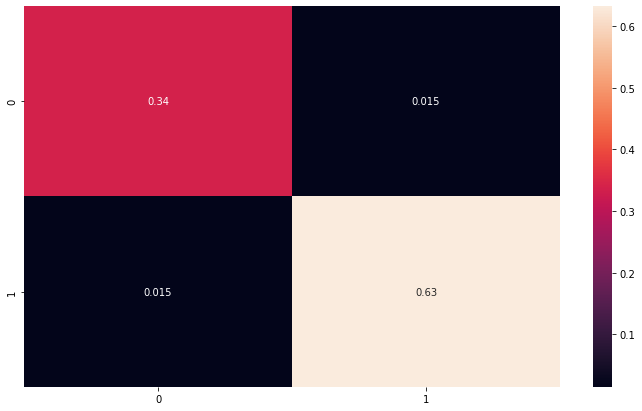

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.98      0.98      0.98        88

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136

---------- Accuracy of testing in Hidden Unit 10: 97.14285714285714%---------- 


In [ ]:
# Loop with differnt number of hidden units
for i in H:
    print(f'******************** Hidden Unit {i} ********************')
    net = Net_binary(n_features, i)
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    # Train the model
    time_start = time.time()
    net, train_acc = train_model(net, n_epochs, es_thres, patience)
    time_end = time.time()
    time_used = time_end - time_start
    bc_time[i] = time_used
    bc_train_acc[i] = train_acc
    print(f'---------- End of training (time: {time_used}) ----------')
    # Test the model
    net, test_acc, test_AUC, df_cm, acc_score, report = test_model(net)
    bc_test_acc[i] = test_acc
    bc_test_AUC[i] = test_AUC
    bc_acc_score[i] = acc_score

    print(f'---------- Accuracy of testing in Hidden Unit {i}: {test_acc}%---------- ')

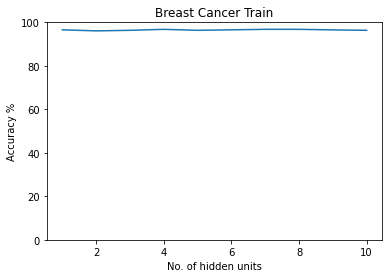

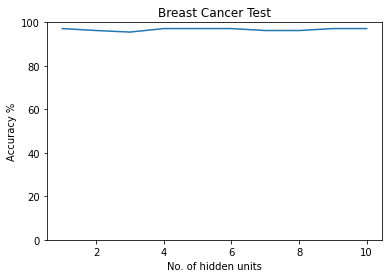

In [ ]:
# Plot the accuracy of different number of hidden units
plot_hidden_units(bc_train_acc, 'Breast Cancer Train')
plot_hidden_units(bc_test_acc, 'Breast Cancer Test')

In [ ]:
# Get the best number of hidden units
bc_best_n = max(bc_test_acc, key=bc_test_acc.get)
bc_best_n

1

### Dataset 2: diabetes

In [ ]:
data2 = 'diabetes'
train_X, train_Y, test_X, test_Y = get_tensor(f'/content/drive/My Drive/HKUST/MSBD5002/datasets/bi-class/{data2}.npz')
n_features = dict_features[data2]

# Create empty dictionaries for storing data
diabetes_train_acc = {}
diabetes_test_acc = {}
diabetes_test_AUC = {}
diabetes_time = {}
diabetes_acc_score = {}

In [ ]:
# Hyperparameters from training
batch_size = 20
n_epochs = 200
patience = 5
es_thres = 0.00001

# Create datasets by batches
train_loader, valid_loader, test_loader = create_datasets(batch_size, train_X, train_Y, test_X, test_Y)

******************** Hidden Unit 1 ********************
('[  1/200]', 'train_loss: 0.65650', 'valid_loss: 0.66404', 'train_acc: 66.00000', 'valid_acc: 63.09524')
('[  2/200]', 'train_loss: 0.65510', 'valid_loss: 0.65144', 'train_acc: 66.13333', 'valid_acc: 67.14286')
('[  3/200]', 'train_loss: 0.65462', 'valid_loss: 0.66208', 'train_acc: 66.00000', 'valid_acc: 63.09524')
('[  4/200]', 'train_loss: 0.65420', 'valid_loss: 0.66204', 'train_acc: 65.86667', 'valid_acc: 63.09524')
('[  5/200]', 'train_loss: 0.65343', 'valid_loss: 0.66224', 'train_acc: 65.86667', 'valid_acc: 63.09524')
('[  6/200]', 'train_loss: 0.65327', 'valid_loss: 0.67485', 'train_acc: 65.73333', 'valid_acc: 59.04762')
('[  7/200]', 'train_loss: 0.65307', 'valid_loss: 0.67487', 'train_acc: 65.60000', 'valid_acc: 59.04762')
('[  8/200]', 'train_loss: 0.65123', 'valid_loss: 0.64700', 'train_acc: 66.00000', 'valid_acc: 67.14286')
('[  9/200]', 'train_loss: 0.65153', 'valid_loss: 0.66137', 'train_acc: 65.73333', 'valid_acc: 6

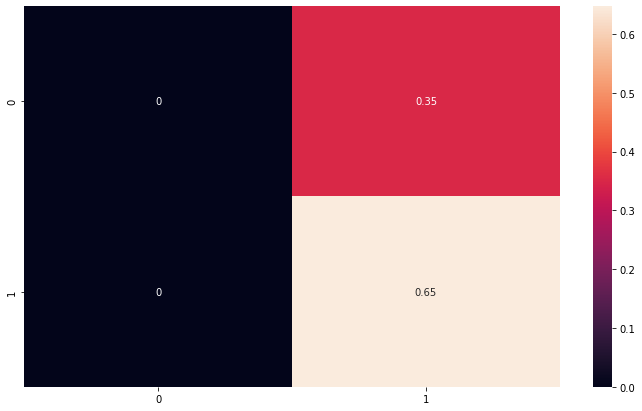

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 1: 64.90384615384616%---------- 
******************** Hidden Unit 2 ********************
('[  1/200]', 'train_loss: 0.67378', 'valid_loss: 0.67618', 'train_acc: 66.00000', 'valid_acc: 63.09524')
('[  2/200]', 'train_loss: 0.67095', 'valid_loss: 0.67475', 'train_acc: 65.73333', 'valid_acc: 63.09524')
('[  3/200]', 'train_loss: 0.66832', 'valid_loss: 0.67252', 'train_acc: 65.73333', 'valid_acc: 63.09524')
('[  4/200]', 'train_loss: 0.66520', 'valid_loss: 0.66157', 'train_acc: 66.00000', 'valid_acc: 67.14286')
('[  5/200]', 'train_loss: 0.66399', 'valid_loss: 0.66866', 'train_acc: 65.60000', 'valid_acc: 63.09524')
('[  6/2

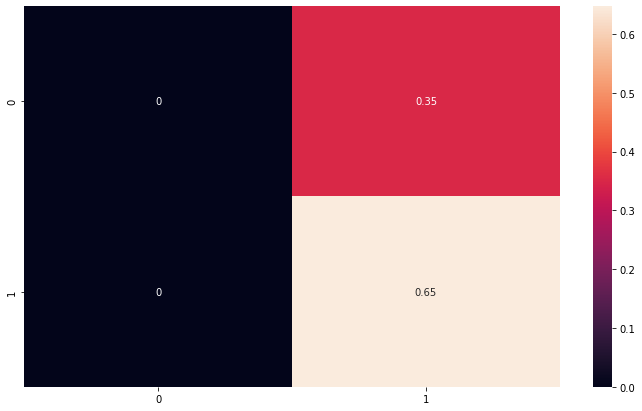

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 2: 64.90384615384616%---------- 
******************** Hidden Unit 3 ********************
('[  1/200]', 'train_loss: 0.70734', 'valid_loss: 0.70095', 'train_acc: 34.13333', 'valid_acc: 36.90476')
('[  2/200]', 'train_loss: 0.70313', 'valid_loss: 0.69727', 'train_acc: 34.40000', 'valid_acc: 36.90476')
('[  3/200]', 'train_loss: 0.69961', 'valid_loss: 0.69304', 'train_acc: 33.53333', 'valid_acc: 40.95238')
('[  4/200]', 'train_loss: 0.69577', 'valid_loss: 0.69022', 'train_acc: 33.66667', 'valid_acc: 40.95238')
('[  5/200]', 'train_loss: 0.69250', 'valid_loss: 0.68869', 'train_acc: 46.00000', 'valid_acc: 75.00000')
('[  6/2

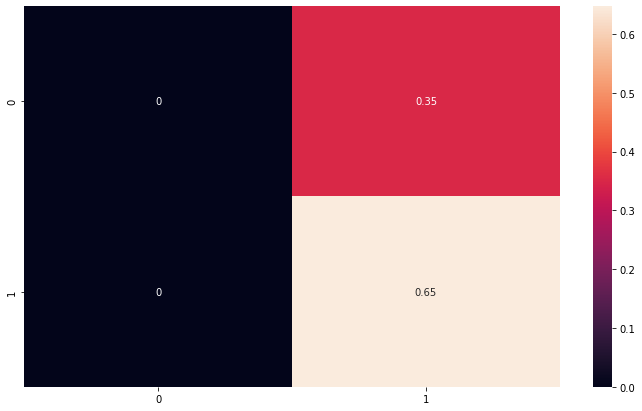

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 3: 64.90384615384616%---------- 
******************** Hidden Unit 4 ********************
('[  1/200]', 'train_loss: 0.69070', 'valid_loss: 0.68617', 'train_acc: 60.86667', 'valid_acc: 66.42857')
('[  2/200]', 'train_loss: 0.68715', 'valid_loss: 0.68456', 'train_acc: 65.33333', 'valid_acc: 66.42857')
('[  3/200]', 'train_loss: 0.68351', 'valid_loss: 0.68357', 'train_acc: 66.00000', 'valid_acc: 63.09524')
('[  4/200]', 'train_loss: 0.68025', 'valid_loss: 0.68181', 'train_acc: 65.80000', 'valid_acc: 63.09524')
('[  5/200]', 'train_loss: 0.67765', 'valid_loss: 0.67257', 'train_acc: 65.60000', 'valid_acc: 67.14286')
('[  6/2

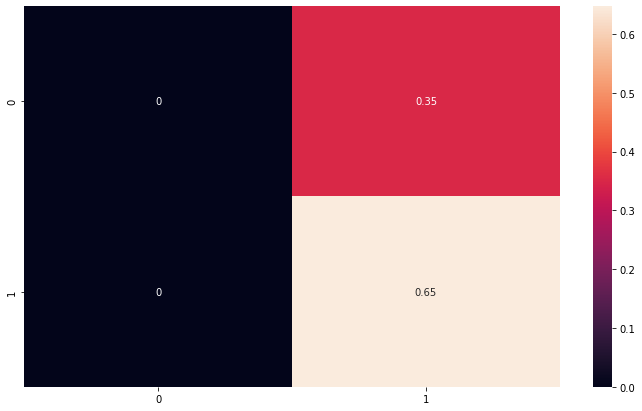

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 4: 64.90384615384616%---------- 
******************** Hidden Unit 5 ********************
('[  1/200]', 'train_loss: 0.69077', 'valid_loss: 0.69118', 'train_acc: 52.13333', 'valid_acc: 58.33333')
('[  2/200]', 'train_loss: 0.68104', 'valid_loss: 0.67536', 'train_acc: 66.26667', 'valid_acc: 67.85714')
('[  3/200]', 'train_loss: 0.67264', 'valid_loss: 0.67346', 'train_acc: 66.93333', 'valid_acc: 62.38095')
('[  4/200]', 'train_loss: 0.66587', 'valid_loss: 0.66073', 'train_acc: 65.73333', 'valid_acc: 67.14286')
('[  5/200]', 'train_loss: 0.65990', 'valid_loss: 0.65692', 'train_acc: 65.86667', 'valid_acc: 67.14286')
('[  6/2

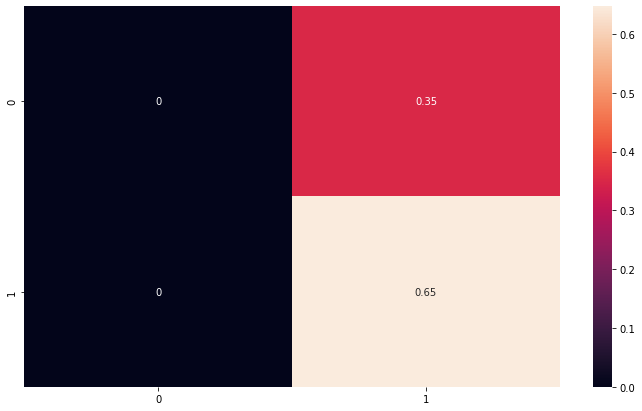

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 5: 64.90384615384616%---------- 
******************** Hidden Unit 6 ********************
('[  1/200]', 'train_loss: 0.75334', 'valid_loss: 0.73050', 'train_acc: 34.26667', 'valid_acc: 40.95238')
('[  2/200]', 'train_loss: 0.74540', 'valid_loss: 0.74638', 'train_acc: 34.53333', 'valid_acc: 32.85714')
('[  3/200]', 'train_loss: 0.73964', 'valid_loss: 0.72991', 'train_acc: 34.13333', 'valid_acc: 36.90476')
('[  4/200]', 'train_loss: 0.73317', 'valid_loss: 0.73159', 'train_acc: 34.13333', 'valid_acc: 32.85714')
('[  5/200]', 'train_loss: 0.72669', 'valid_loss: 0.71940', 'train_acc: 34.53333', 'valid_acc: 36.90476')
('[  6/2

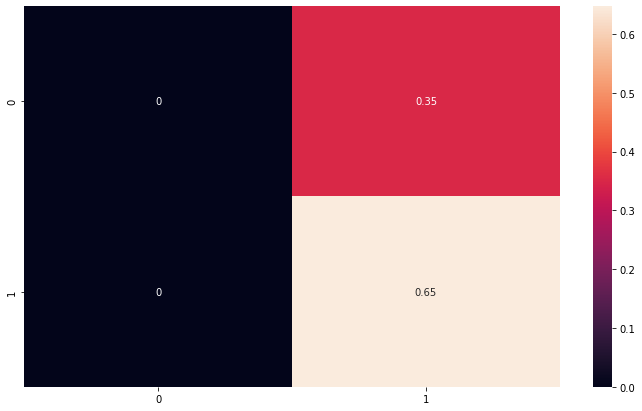

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 6: 64.90384615384616%---------- 
******************** Hidden Unit 7 ********************
('[  1/200]', 'train_loss: 0.68172', 'valid_loss: 0.67841', 'train_acc: 65.93333', 'valid_acc: 69.28571')
('[  2/200]', 'train_loss: 0.67755', 'valid_loss: 0.67720', 'train_acc: 66.60000', 'valid_acc: 63.80952')
('[  3/200]', 'train_loss: 0.67446', 'valid_loss: 0.68051', 'train_acc: 65.33333', 'valid_acc: 59.04762')
('[  4/200]', 'train_loss: 0.67029', 'valid_loss: 0.66636', 'train_acc: 65.93333', 'valid_acc: 67.85714')
('[  5/200]', 'train_loss: 0.66722', 'valid_loss: 0.66836', 'train_acc: 65.60000', 'valid_acc: 62.38095')
('[  6/2

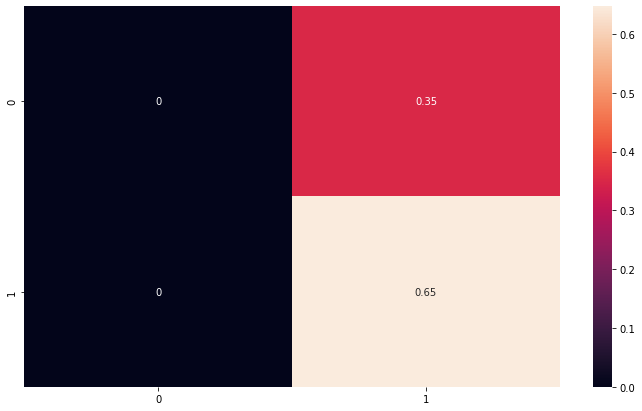

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 7: 64.90384615384616%---------- 
******************** Hidden Unit 8 ********************
('[  1/200]', 'train_loss: 0.68449', 'valid_loss: 0.68474', 'train_acc: 65.86667', 'valid_acc: 63.09524')
('[  2/200]', 'train_loss: 0.68183', 'valid_loss: 0.68396', 'train_acc: 66.00000', 'valid_acc: 63.09524')
('[  3/200]', 'train_loss: 0.67991', 'valid_loss: 0.68202', 'train_acc: 65.60000', 'valid_acc: 63.09524')
('[  4/200]', 'train_loss: 0.67752', 'valid_loss: 0.68540', 'train_acc: 65.86667', 'valid_acc: 59.04762')
('[  5/200]', 'train_loss: 0.67513', 'valid_loss: 0.67238', 'train_acc: 66.13333', 'valid_acc: 67.14286')
('[  6/2

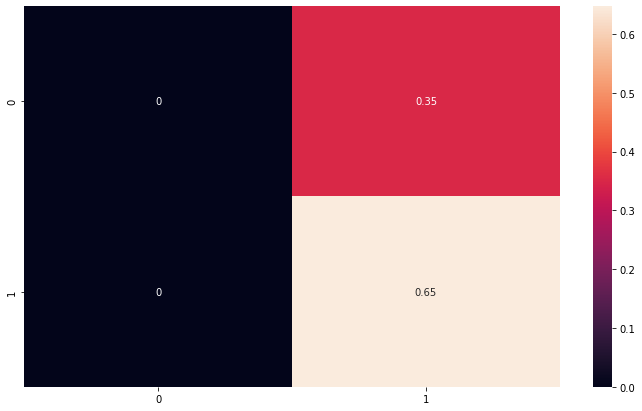

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 8: 64.90384615384616%---------- 
******************** Hidden Unit 9 ********************
('[  1/200]', 'train_loss: 0.67343', 'valid_loss: 0.66842', 'train_acc: 64.73333', 'valid_acc: 62.38095')
('[  2/200]', 'train_loss: 0.66654', 'valid_loss: 0.66783', 'train_acc: 66.00000', 'valid_acc: 63.09524')
('[  3/200]', 'train_loss: 0.66145', 'valid_loss: 0.65583', 'train_acc: 65.86667', 'valid_acc: 67.14286')
('[  4/200]', 'train_loss: 0.65576', 'valid_loss: 0.67222', 'train_acc: 66.40000', 'valid_acc: 59.04762')
('[  5/200]', 'train_loss: 0.65342', 'valid_loss: 0.64724', 'train_acc: 65.86667', 'valid_acc: 67.14286')
('[  6/2

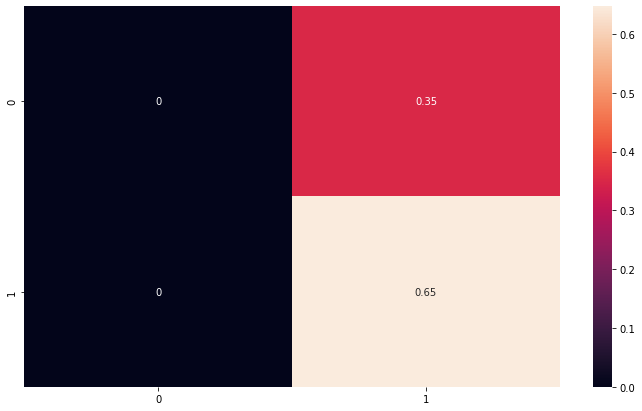

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 9: 64.90384615384616%---------- 
******************** Hidden Unit 10 ********************
('[  1/200]', 'train_loss: 0.67533', 'valid_loss: 0.67862', 'train_acc: 68.66667', 'valid_acc: 64.04762')
('[  2/200]', 'train_loss: 0.67113', 'valid_loss: 0.66665', 'train_acc: 68.06667', 'valid_acc: 69.28571')
('[  3/200]', 'train_loss: 0.66706', 'valid_loss: 0.67475', 'train_acc: 66.20000', 'valid_acc: 60.47619')
('[  4/200]', 'train_loss: 0.66400', 'valid_loss: 0.66596', 'train_acc: 66.40000', 'valid_acc: 63.09524')
('[  5/200]', 'train_loss: 0.66155', 'valid_loss: 0.65729', 'train_acc: 66.26667', 'valid_acc: 67.14286')
('[  6/

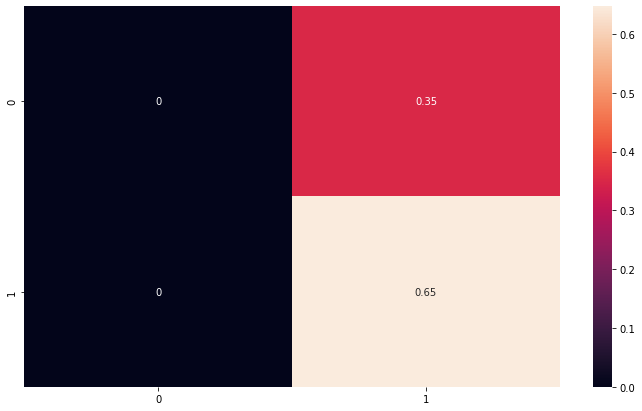

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79        99

    accuracy                           0.65       153
   macro avg       0.32      0.50      0.39       153
weighted avg       0.42      0.65      0.51       153

---------- Accuracy of testing in Hidden Unit 10: 64.90384615384616%---------- 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Loop with differnt number of hidden units
for i in H:
    print(f'******************** Hidden Unit {i} ********************')
    net = Net_binary(n_features, i)
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    # Train the model
    time_start = time.time()
    net, train_acc = train_model(net, n_epochs, es_thres, patience)
    time_end = time.time()
    time_used = time_end - time_start
    diabetes_time[i] = time_used
    diabetes_train_acc[i] = train_acc
    print(f'---------- End of training (time: {time_used}) ----------')
    # Test the model
    net, test_acc, test_AUC, df_cm, acc_score, report = test_model(net)
    diabetes_test_acc[i] = test_acc
    diabetes_test_AUC[i] = test_AUC
    diabetes_acc_score[i] = acc_score

    print(f'---------- Accuracy of testing in Hidden Unit {i}: {test_acc}%---------- ')

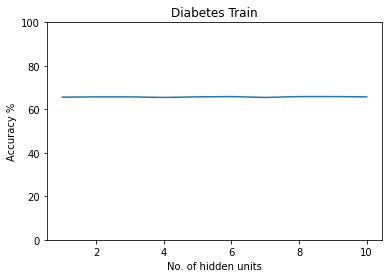

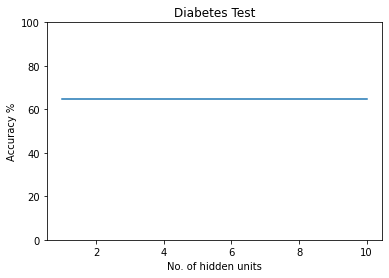

In [ ]:
# Plot the accuracy of different number of hidden units
plot_hidden_units(diabetes_train_acc, 'Diabetes Train')
plot_hidden_units(diabetes_test_acc, 'Diabetes Test')

In [ ]:
# Get the best number of hidden units
diabetes_best_n = max(diabetes_test_acc, key=diabetes_test_acc.get)
diabetes_best_n

1

### Dataset 3: iris

In [ ]:
data3 = 'iris'
train_X, train_Y, test_X, test_Y = get_tensor(f'/content/drive/My Drive/HKUST/MSBD5002/datasets/bi-class/{data3}.npz')
n_features = dict_features[data3]

# Create empty dictionaries for storing data
iris_train_acc = {}
iris_test_acc = {}
iris_test_AUC = {}
iris_time = {}
iris_acc_score = {}

In [ ]:
# Hyperparameters from training
batch_size = 20
n_epochs = 200
patience = 5
es_thres = 0.00001

# Create datasets by batches
train_loader, valid_loader, test_loader = create_datasets(batch_size, train_X, train_Y, test_X, test_Y)

******************** Hidden Unit 1 ********************
('[  1/200]', 'train_loss: 0.65979', 'valid_loss: 0.64020', 'train_acc: 65.50000', 'valid_acc: 72.50000')
('[  2/200]', 'train_loss: 0.65822', 'valid_loss: 0.63990', 'train_acc: 66.00000', 'valid_acc: 72.50000')
('[  3/200]', 'train_loss: 0.65805', 'valid_loss: 0.63960', 'train_acc: 66.00000', 'valid_acc: 72.50000')
('[  4/200]', 'train_loss: 0.65578', 'valid_loss: 0.63928', 'train_acc: 66.75000', 'valid_acc: 72.50000')
('[  5/200]', 'train_loss: 0.65771', 'valid_loss: 0.61039', 'train_acc: 66.00000', 'valid_acc: 82.50000')
('[  6/200]', 'train_loss: 0.65897', 'valid_loss: 0.66749', 'train_acc: 65.50000', 'valid_acc: 62.50000')
('[  7/200]', 'train_loss: 0.65811', 'valid_loss: 0.60949', 'train_acc: 65.75000', 'valid_acc: 82.50000')
('[  8/200]', 'train_loss: 0.66162', 'valid_loss: 0.63821', 'train_acc: 64.50000', 'valid_acc: 72.50000')
('[  9/200]', 'train_loss: 0.65781', 'valid_loss: 0.63794', 'train_acc: 65.75000', 'valid_acc: 7

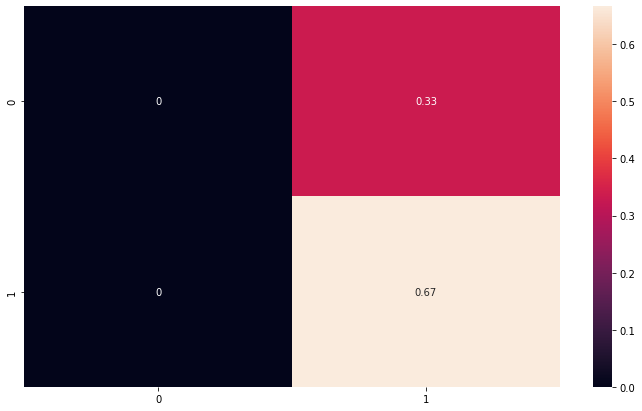

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30

---------- Accuracy of testing in Hidden Unit 1: 67.5%---------- 
******************** Hidden Unit 2 ********************
('[  1/200]', 'train_loss: 0.64325', 'valid_loss: 0.67408', 'train_acc: 65.75000', 'valid_acc: 62.50000')
('[  2/200]', 'train_loss: 0.64282', 'valid_loss: 0.57960', 'train_acc: 65.75000', 'valid_acc: 72.50000')
('[  3/200]', 'train_loss: 0.64712', 'valid_loss: 0.57894', 'train_acc: 65.25000', 'valid_acc: 72.50000')
('[  4/200]', 'train_loss: 0.64208', 'valid_loss: 0.76318', 'train_acc: 65.75000', 'valid_acc: 52.50000')
('[  5/200]', 'train_loss: 0.63926', 'valid_loss: 0.48530', 'train_acc: 66.00000', 'valid_acc: 82.50000')
('[  6/200]', 'train_

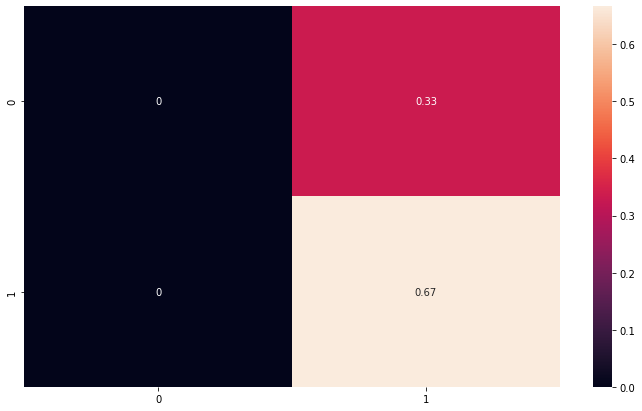

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30

---------- Accuracy of testing in Hidden Unit 2: 67.5%---------- 
******************** Hidden Unit 3 ********************
('[  1/200]', 'train_loss: 0.89635', 'valid_loss: 0.90441', 'train_acc: 0.00000', 'valid_acc: 2.50000')
('[  2/200]', 'train_loss: 0.83593', 'valid_loss: 0.79380', 'train_acc: 7.25000', 'valid_acc: 27.50000')
('[  3/200]', 'train_loss: 0.77235', 'valid_loss: 0.77018', 'train_acc: 58.00000', 'valid_acc: 60.00000')
('[  4/200]', 'train_loss: 0.73040', 'valid_loss: 0.68652', 'train_acc: 66.00000', 'valid_acc: 72.50000')
('[  5/200]', 'train_loss: 0.71007', 'valid_loss: 0.58345', 'train_acc: 65.25000', 'valid_acc: 82.50000')
('[  6/200]', 'train_los

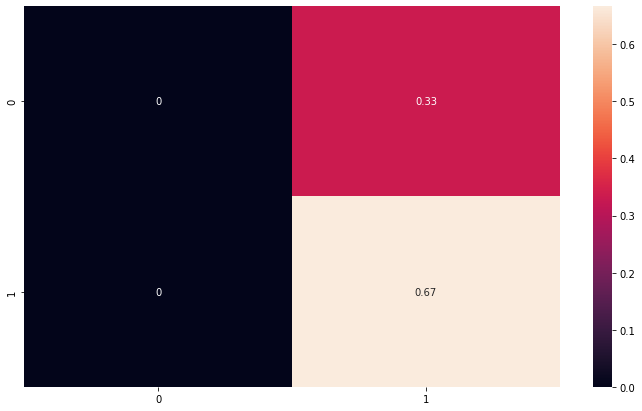

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30

---------- Accuracy of testing in Hidden Unit 3: 67.5%---------- 
******************** Hidden Unit 4 ********************
('[  1/200]', 'train_loss: 0.70247', 'valid_loss: 0.72106', 'train_acc: 66.00000', 'valid_acc: 62.50000')
('[  2/200]', 'train_loss: 0.68887', 'valid_loss: 0.70954', 'train_acc: 66.25000', 'valid_acc: 62.50000')
('[  3/200]', 'train_loss: 0.67953', 'valid_loss: 0.64287', 'train_acc: 66.25000', 'valid_acc: 72.50000')
('[  4/200]', 'train_loss: 0.67937', 'valid_loss: 0.69389', 'train_acc: 65.00000', 'valid_acc: 62.50000')
('[  5/200]', 'train_loss: 0.67076', 'valid_loss: 0.62460', 'train_acc: 65.50000', 'valid_acc: 72.50000')
('[  6/200]', 'train_

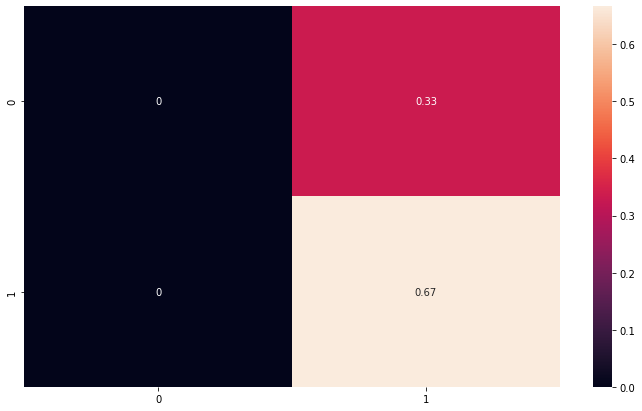

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30

---------- Accuracy of testing in Hidden Unit 4: 67.5%---------- 
******************** Hidden Unit 5 ********************
('[  1/200]', 'train_loss: 0.68864', 'valid_loss: 0.68505', 'train_acc: 35.75000', 'valid_acc: 50.00000')
('[  2/200]', 'train_loss: 0.62854', 'valid_loss: 0.59660', 'train_acc: 69.75000', 'valid_acc: 97.50000')
('[  3/200]', 'train_loss: 0.58303', 'valid_loss: 0.55799', 'train_acc: 100.00000', 'valid_acc: 100.00000')
('[  4/200]', 'train_loss: 0.55775', 'valid_loss: 0.54403', 'train_acc: 100.00000', 'valid_acc: 100.00000')
('[  5/200]', 'train_loss: 0.54152', 'valid_loss: 0.51743', 'train_acc: 100.00000', 'valid_acc: 100.00000')
('[  6/200]', '

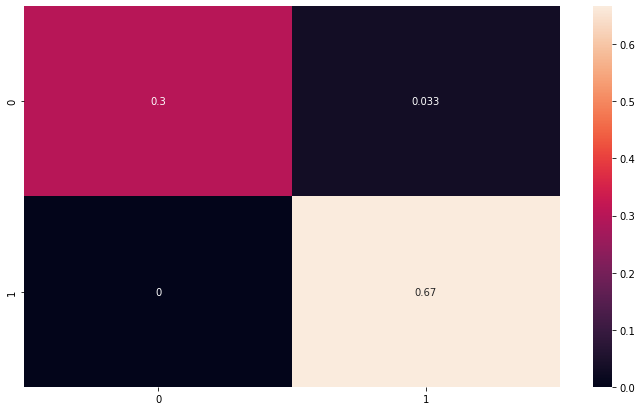

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.95      1.00      0.98        20

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30

---------- Accuracy of testing in Hidden Unit 5: 95.0%---------- 
******************** Hidden Unit 6 ********************
('[  1/200]', 'train_loss: 0.74317', 'valid_loss: 0.73434', 'train_acc: 35.00000', 'valid_acc: 37.50000')
('[  2/200]', 'train_loss: 0.73530', 'valid_loss: 0.74010', 'train_acc: 34.00000', 'valid_acc: 27.50000')
('[  3/200]', 'train_loss: 0.72714', 'valid_loss: 0.73168', 'train_acc: 33.75000', 'valid_acc: 27.50000')
('[  4/200]', 'train_loss: 0.71983', 'valid_loss: 0.70202', 'train_acc: 34.00000', 'valid_acc: 47.50000')
('[  5/200]', 'train_loss: 0.71297', 'valid_loss: 0.71648', 'train_acc: 34.75000', 'valid_acc: 27.50000')
('[  6/200]', 'train_

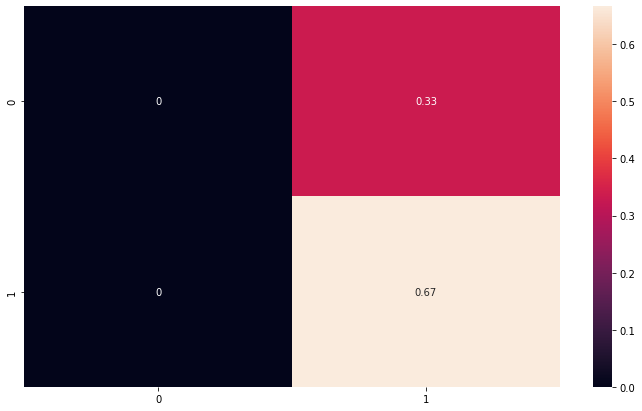

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30

---------- Accuracy of testing in Hidden Unit 6: 67.5%---------- 
******************** Hidden Unit 7 ********************
('[  1/200]', 'train_loss: 0.64277', 'valid_loss: 0.59442', 'train_acc: 66.50000', 'valid_acc: 72.50000')
('[  2/200]', 'train_loss: 0.64640', 'valid_loss: 0.59348', 'train_acc: 65.75000', 'valid_acc: 72.50000')
('[  3/200]', 'train_loss: 0.64849', 'valid_loss: 0.51561', 'train_acc: 65.25000', 'valid_acc: 82.50000')
('[  4/200]', 'train_loss: 0.64094', 'valid_loss: 0.66825', 'train_acc: 66.00000', 'valid_acc: 62.50000')
('[  5/200]', 'train_loss: 0.64271', 'valid_loss: 0.58872', 'train_acc: 65.50000', 'valid_acc: 72.50000')
('[  6/200]', 'train_

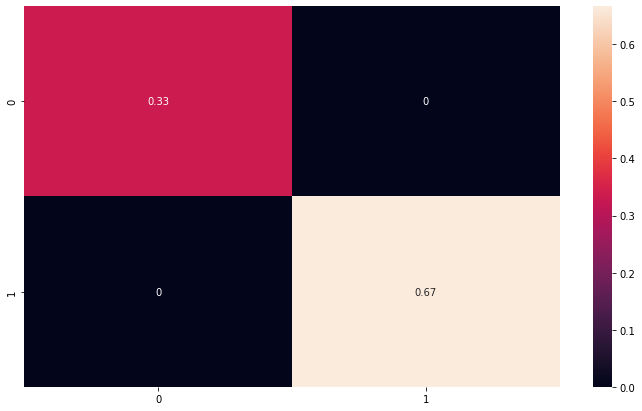

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        20

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

---------- Accuracy of testing in Hidden Unit 7: 100.0%---------- 
******************** Hidden Unit 8 ********************
('[  1/200]', 'train_loss: 0.84333', 'valid_loss: 0.88245', 'train_acc: 34.00000', 'valid_acc: 27.50000')
('[  2/200]', 'train_loss: 0.82478', 'valid_loss: 0.90448', 'train_acc: 34.00000', 'valid_acc: 17.50000')
('[  3/200]', 'train_loss: 0.80417', 'valid_loss: 0.77457', 'train_acc: 34.25000', 'valid_acc: 37.50000')
('[  4/200]', 'train_loss: 0.78605', 'valid_loss: 0.76908', 'train_acc: 34.25000', 'valid_acc: 37.50000')
('[  5/200]', 'train_loss: 0.77029', 'valid_loss: 0.74949', 'train_acc: 33.75000', 'valid_acc: 37.50000')
('[  6/200]', 'train

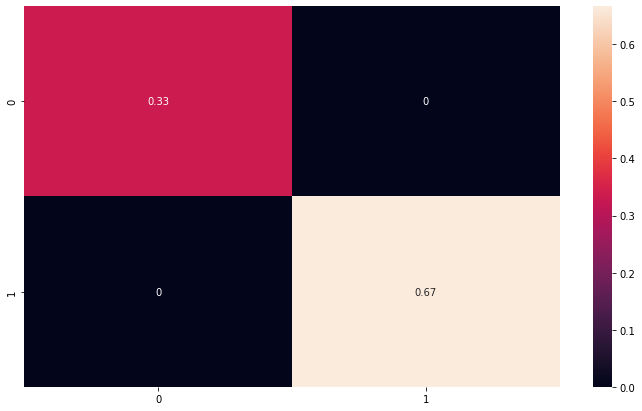

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        20

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

---------- Accuracy of testing in Hidden Unit 8: 100.0%---------- 
******************** Hidden Unit 9 ********************
('[  1/200]', 'train_loss: 0.54131', 'valid_loss: 0.45926', 'train_acc: 65.50000', 'valid_acc: 82.50000')
('[  2/200]', 'train_loss: 0.53628', 'valid_loss: 0.58215', 'train_acc: 65.25000', 'valid_acc: 52.50000')
('[  3/200]', 'train_loss: 0.53003', 'valid_loss: 0.45102', 'train_acc: 65.25000', 'valid_acc: 82.50000')
('[  4/200]', 'train_loss: 0.52279', 'valid_loss: 0.49684', 'train_acc: 65.75000', 'valid_acc: 72.50000')
('[  5/200]', 'train_loss: 0.51896', 'valid_loss: 0.48802', 'train_acc: 65.25000', 'valid_acc: 72.50000')
('[  6/200]', 'train

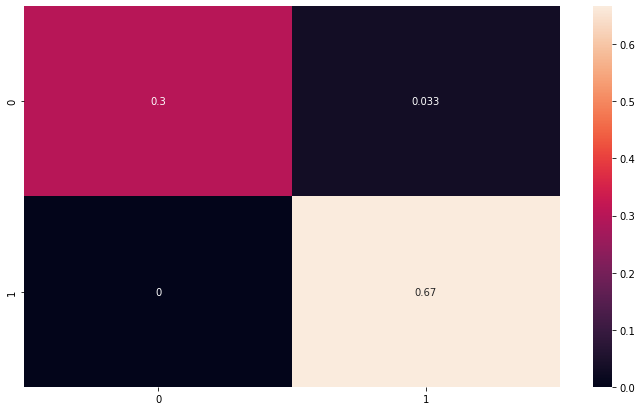

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.95      1.00      0.98        20

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30

---------- Accuracy of testing in Hidden Unit 9: 97.5%---------- 
******************** Hidden Unit 10 ********************
('[  1/200]', 'train_loss: 0.60869', 'valid_loss: 0.59104', 'train_acc: 98.75000', 'valid_acc: 85.00000')
('[  2/200]', 'train_loss: 0.59190', 'valid_loss: 0.57217', 'train_acc: 74.00000', 'valid_acc: 75.00000')
('[  3/200]', 'train_loss: 0.58215', 'valid_loss: 0.55545', 'train_acc: 65.75000', 'valid_acc: 72.50000')
('[  4/200]', 'train_loss: 0.57590', 'valid_loss: 0.54351', 'train_acc: 65.50000', 'valid_acc: 72.50000')
('[  5/200]', 'train_loss: 0.57280', 'valid_loss: 0.56609', 'train_acc: 65.00000', 'valid_acc: 62.50000')
('[  6/200]', 'train

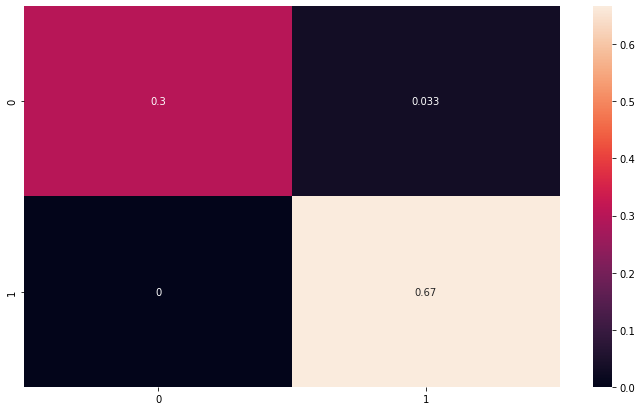

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.95      1.00      0.98        20

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30

---------- Accuracy of testing in Hidden Unit 10: 97.5%---------- 


In [ ]:
# Loop with differnt number of hidden units
for i in H:
    print(f'******************** Hidden Unit {i} ********************')
    net = Net_binary(n_features, i)
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    # Train the model
    time_start = time.time()
    net, train_acc = train_model(net, n_epochs, es_thres, patience)
    time_end = time.time()
    time_used = time_end - time_start
    iris_time[i] = time_used
    iris_train_acc[i] = train_acc
    print(f'---------- End of training (time: {time_used}) ----------')
    # Test the model
    net, test_acc, test_AUC, df_cm, acc_score, report = test_model(net)
    iris_test_acc[i] = test_acc
    iris_test_AUC[i] = test_AUC
    iris_acc_score[i] = acc_score

    print(f'---------- Accuracy of testing in Hidden Unit {i}: {test_acc}%---------- ')

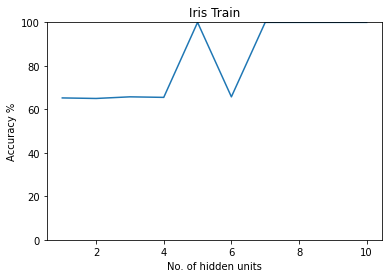

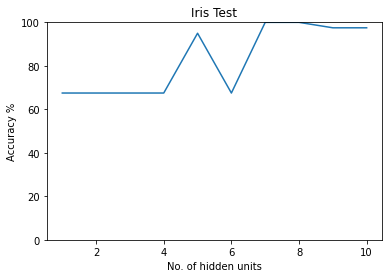

In [ ]:
# Plot the accuracy of different number of hidden units
plot_hidden_units(iris_train_acc, 'Iris Train')
plot_hidden_units(iris_test_acc, 'Iris Test')

In [ ]:
# Get the best number of hidden units
iris_best_n = max(iris_test_acc, key=iris_test_acc.get)
iris_best_n

7

### Dateset 4: wine

In [ ]:
data4 = 'wine'
train_X, train_Y, test_X, test_Y = get_tensor(f'/content/drive/My Drive/HKUST/MSBD5002/datasets/bi-class/{data4}.npz')
n_features = dict_features[data4]
wine_train_acc = {}
wine_test_acc = {}
wine_test_AUC = {}
wine_time = {}
wine_acc_score = {}

In [ ]:
# Hyperparameters from training
batch_size = 20
n_epochs = 200
patience = 5
es_thres = 0.00001

# Create datasets by batches
train_loader, valid_loader, test_loader = create_datasets(batch_size, train_X, train_Y, test_X, test_Y)

******************** Hidden Unit 1 ********************
('[  1/200]', 'train_loss: 0.69296', 'valid_loss: 0.74159', 'train_acc: 61.90476', 'valid_acc: 56.25000')
('[  2/200]', 'train_loss: 0.80436', 'valid_loss: 0.87583', 'train_acc: 49.76190', 'valid_acc: 43.75000')
('[  3/200]', 'train_loss: 0.92161', 'valid_loss: 0.91333', 'train_acc: 39.16667', 'valid_acc: 40.00000')
('[  4/200]', 'train_loss: 0.93232', 'valid_loss: 0.83833', 'train_acc: 38.09524', 'valid_acc: 47.50000')
('[  5/200]', 'train_loss: 0.93232', 'valid_loss: 0.83833', 'train_acc: 38.09524', 'valid_acc: 47.50000')
('[  6/200]', 'train_loss: 0.93946', 'valid_loss: 0.91336', 'train_acc: 37.38095', 'valid_acc: 40.00000')
('[  7/200]', 'train_loss: 0.93232', 'valid_loss: 0.80085', 'train_acc: 38.09524', 'valid_acc: 51.25000')
('[  8/200]', 'train_loss: 0.91446', 'valid_loss: 0.83835', 'train_acc: 39.88095', 'valid_acc: 47.50000')
('[  9/200]', 'train_loss: 0.93589', 'valid_loss: 0.91333', 'train_acc: 37.73810', 'valid_acc: 4

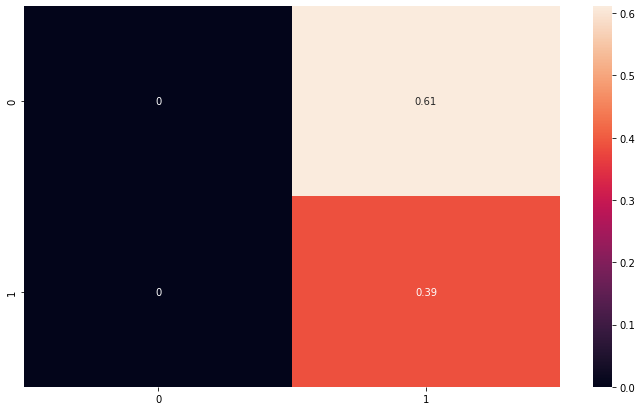

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 1: 37.5%---------- 
******************** Hidden Unit 2 ********************
('[  1/200]', 'train_loss: 0.92874', 'valid_loss: 0.80076', 'train_acc: 38.45238', 'valid_acc: 51.25000')
('[  2/200]', 'train_loss: 0.91802', 'valid_loss: 0.91326', 'train_acc: 39.52381', 'valid_acc: 40.00000')
('[  3/200]', 'train_loss: 0.92874', 'valid_loss: 0.87576', 'train_acc: 38.45238', 'valid_acc: 43.75000')
('[  4/200]', 'train_loss: 0.93588', 'valid_loss: 0.87576', 'train_acc: 37.73810', 'valid_acc: 43.75000')
('[  5/200]', 'train_loss: 0.93231', 'valid_loss: 0.95076', 'train_acc: 38.09524', 'valid_acc: 36.25000')
('[  6/200]', 'train_

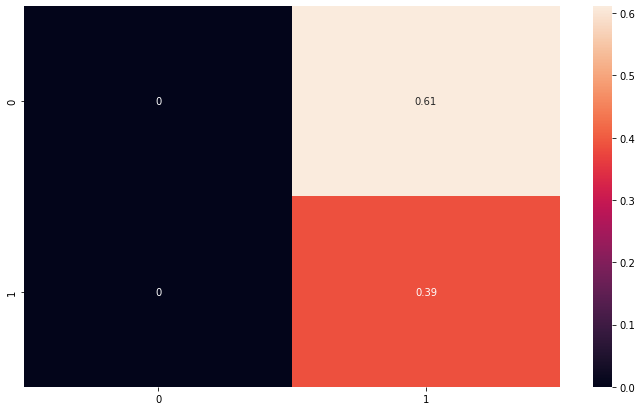

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 2: 37.5%---------- 
******************** Hidden Unit 3 ********************
('[  1/200]', 'train_loss: 0.91445', 'valid_loss: 0.87576', 'train_acc: 39.88095', 'valid_acc: 43.75000')
('[  2/200]', 'train_loss: 0.93588', 'valid_loss: 0.80076', 'train_acc: 37.73810', 'valid_acc: 51.25000')
('[  3/200]', 'train_loss: 0.92874', 'valid_loss: 0.83826', 'train_acc: 38.45238', 'valid_acc: 47.50000')
('[  4/200]', 'train_loss: 0.92160', 'valid_loss: 0.91326', 'train_acc: 39.16667', 'valid_acc: 40.00000')
('[  5/200]', 'train_loss: 0.92517', 'valid_loss: 0.87576', 'train_acc: 38.80952', 'valid_acc: 43.75000')
('[  6/200]', 'train_

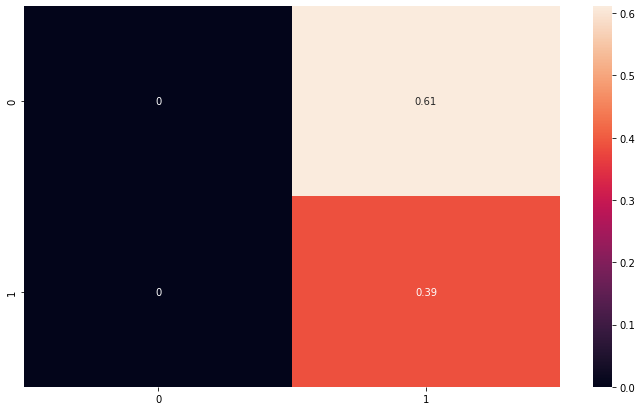

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 3: 37.5%---------- 
******************** Hidden Unit 4 ********************
('[  1/200]', 'train_loss: 0.92874', 'valid_loss: 0.87576', 'train_acc: 38.45238', 'valid_acc: 43.75000')
('[  2/200]', 'train_loss: 0.92517', 'valid_loss: 0.83826', 'train_acc: 38.80952', 'valid_acc: 47.50000')
('[  3/200]', 'train_loss: 0.93945', 'valid_loss: 0.83826', 'train_acc: 37.38095', 'valid_acc: 47.50000')
('[  4/200]', 'train_loss: 0.92160', 'valid_loss: 0.80076', 'train_acc: 39.16667', 'valid_acc: 51.25000')
('[  5/200]', 'train_loss: 0.92874', 'valid_loss: 0.72576', 'train_acc: 38.45238', 'valid_acc: 58.75000')
('[  6/200]', 'train_

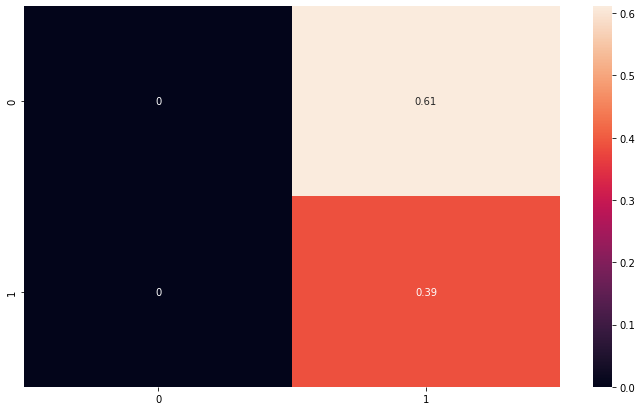

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 4: 37.5%---------- 
******************** Hidden Unit 5 ********************
('[  1/200]', 'train_loss: 0.69779', 'valid_loss: 0.78826', 'train_acc: 61.54762', 'valid_acc: 52.50000')
('[  2/200]', 'train_loss: 0.70136', 'valid_loss: 0.78826', 'train_acc: 61.19048', 'valid_acc: 52.50000')
('[  3/200]', 'train_loss: 0.69779', 'valid_loss: 0.75076', 'train_acc: 61.54762', 'valid_acc: 56.25000')
('[  4/200]', 'train_loss: 0.70493', 'valid_loss: 0.82576', 'train_acc: 60.83333', 'valid_acc: 48.75000')
('[  5/200]', 'train_loss: 0.69421', 'valid_loss: 0.78826', 'train_acc: 61.90476', 'valid_acc: 52.50000')
('[  6/200]', 'train_

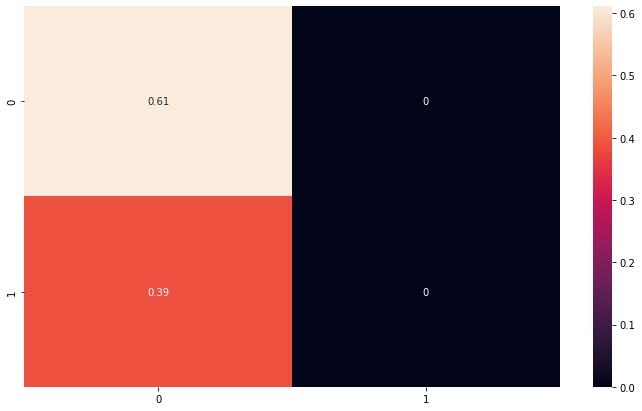

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        22
           1       0.00      0.00      0.00        14

    accuracy                           0.61        36
   macro avg       0.31      0.50      0.38        36
weighted avg       0.37      0.61      0.46        36

---------- Accuracy of testing in Hidden Unit 5: 62.5%---------- 
******************** Hidden Unit 6 ********************
('[  1/200]', 'train_loss: 0.92160', 'valid_loss: 0.87576', 'train_acc: 39.16667', 'valid_acc: 43.75000')
('[  2/200]', 'train_loss: 0.92517', 'valid_loss: 0.91326', 'train_acc: 38.80952', 'valid_acc: 40.00000')
('[  3/200]', 'train_loss: 0.92160', 'valid_loss: 0.87576', 'train_acc: 39.16667', 'valid_acc: 43.75000')
('[  4/200]', 'train_loss: 0.92874', 'valid_loss: 0.95076', 'train_acc: 38.45238', 'valid_acc: 36.25000')
('[  5/200]', 'train_loss: 0.93231', 'valid_loss: 0.87576', 'train_acc: 38.09524', 'valid_acc: 43.75000')
('[  6/200]', 'train_

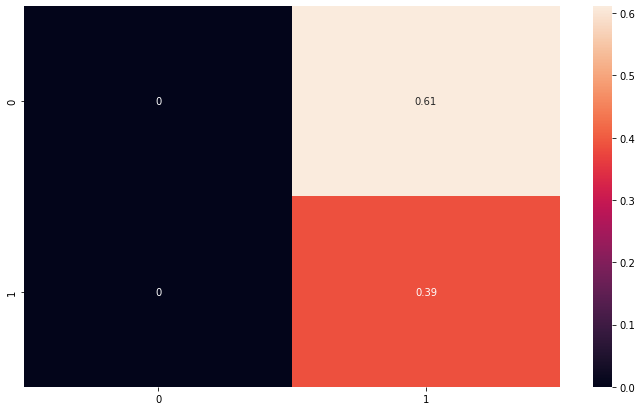

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 6: 37.5%---------- 
******************** Hidden Unit 7 ********************
('[  1/200]', 'train_loss: 0.92160', 'valid_loss: 0.80076', 'train_acc: 39.16667', 'valid_acc: 51.25000')
('[  2/200]', 'train_loss: 0.93945', 'valid_loss: 0.91326', 'train_acc: 37.38095', 'valid_acc: 40.00000')
('[  3/200]', 'train_loss: 0.92517', 'valid_loss: 0.83826', 'train_acc: 38.80952', 'valid_acc: 47.50000')
('[  4/200]', 'train_loss: 0.93588', 'valid_loss: 0.80076', 'train_acc: 37.73810', 'valid_acc: 51.25000')
('[  5/200]', 'train_loss: 0.91445', 'valid_loss: 0.95076', 'train_acc: 39.88095', 'valid_acc: 36.25000')
('[  6/200]', 'train_

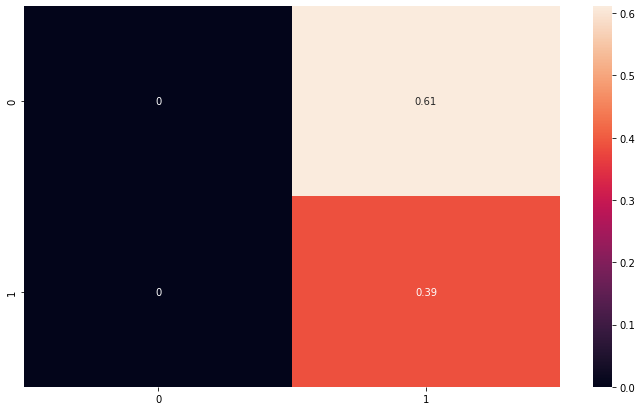

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 7: 37.5%---------- 
******************** Hidden Unit 8 ********************
('[  1/200]', 'train_loss: 0.70850', 'valid_loss: 0.82576', 'train_acc: 60.47619', 'valid_acc: 48.75000')
('[  2/200]', 'train_loss: 0.71564', 'valid_loss: 0.82576', 'train_acc: 59.76190', 'valid_acc: 48.75000')
('[  3/200]', 'train_loss: 0.70850', 'valid_loss: 0.75076', 'train_acc: 60.47619', 'valid_acc: 56.25000')
('[  4/200]', 'train_loss: 0.70850', 'valid_loss: 0.75076', 'train_acc: 60.47619', 'valid_acc: 56.25000')
('[  5/200]', 'train_loss: 0.69779', 'valid_loss: 0.75076', 'train_acc: 61.54762', 'valid_acc: 56.25000')
('[  6/200]', 'train_

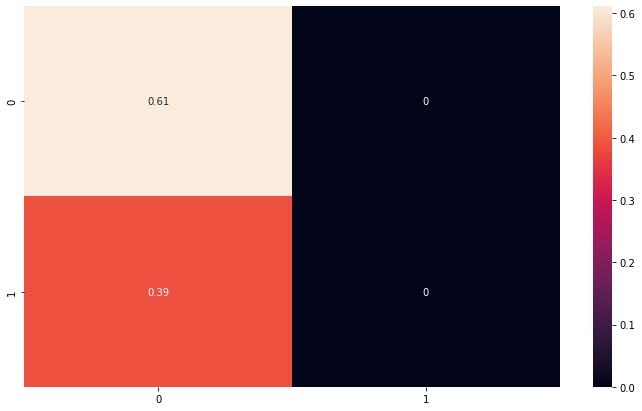

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        22
           1       0.00      0.00      0.00        14

    accuracy                           0.61        36
   macro avg       0.31      0.50      0.38        36
weighted avg       0.37      0.61      0.46        36

---------- Accuracy of testing in Hidden Unit 8: 62.5%---------- 
******************** Hidden Unit 9 ********************
('[  1/200]', 'train_loss: 0.92388', 'valid_loss: 0.87752', 'train_acc: 39.16667', 'valid_acc: 43.75000')
('[  2/200]', 'train_loss: 0.93271', 'valid_loss: 0.76502', 'train_acc: 38.09524', 'valid_acc: 55.00000')
('[  3/200]', 'train_loss: 0.92903', 'valid_loss: 0.76491', 'train_acc: 38.45238', 'valid_acc: 55.00000')
('[  4/200]', 'train_loss: 0.91825', 'valid_loss: 0.87641', 'train_acc: 39.52381', 'valid_acc: 43.75000')
('[  5/200]', 'train_loss: 0.92892', 'valid_loss: 0.91374', 'train_acc: 38.45238', 'valid_acc: 40.00000')
('[  6/200]', 'train_

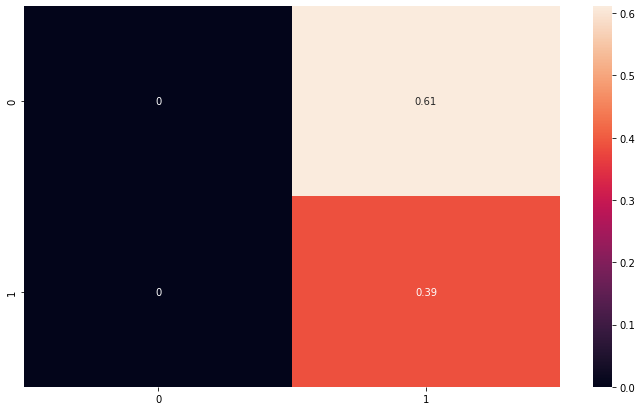

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.39      1.00      0.56        14

    accuracy                           0.39        36
   macro avg       0.19      0.50      0.28        36
weighted avg       0.15      0.39      0.22        36

---------- Accuracy of testing in Hidden Unit 9: 37.5%---------- 
******************** Hidden Unit 10 ********************
('[  1/200]', 'train_loss: 0.72446', 'valid_loss: 0.71326', 'train_acc: 58.57143', 'valid_acc: 60.00000')
('[  2/200]', 'train_loss: 0.69779', 'valid_loss: 0.86326', 'train_acc: 61.54762', 'valid_acc: 45.00000')
('[  3/200]', 'train_loss: 0.70493', 'valid_loss: 0.78826', 'train_acc: 60.83333', 'valid_acc: 52.50000')
('[  4/200]', 'train_loss: 0.70136', 'valid_loss: 0.75076', 'train_acc: 61.19048', 'valid_acc: 56.25000')
('[  5/200]', 'train_loss: 0.69421', 'valid_loss: 0.75076', 'train_acc: 61.90476', 'valid_acc: 56.25000')
('[  6/200]', 'train

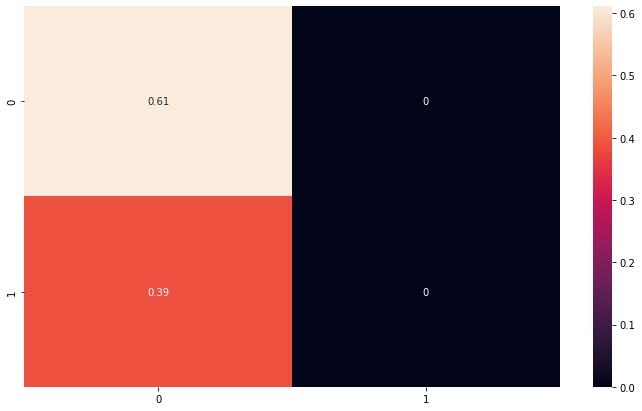

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        22
           1       0.00      0.00      0.00        14

    accuracy                           0.61        36
   macro avg       0.31      0.50      0.38        36
weighted avg       0.37      0.61      0.46        36

---------- Accuracy of testing in Hidden Unit 10: 62.5%---------- 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Loop with differnt number of hidden units
for i in H:
    print(f'******************** Hidden Unit {i} ********************')
    net = Net_binary(n_features, i)
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    # Train the model
    time_start = time.time()
    net, train_acc = train_model(net, n_epochs, es_thres, patience)
    time_end = time.time()
    time_used = time_end - time_start
    wine_time[i] = time_used
    wine_train_acc[i] = train_acc
    print(f'---------- End of training (time: {time_used}) ----------')
    # Test the model
    net, test_acc, test_AUC, df_cm, acc_score, report = test_model(net)
    wine_test_acc[i] = test_acc
    wine_test_AUC[i] = test_AUC
    wine_acc_score[i] = acc_score

    print(f'---------- Accuracy of testing in Hidden Unit {i}: {test_acc}%---------- ')

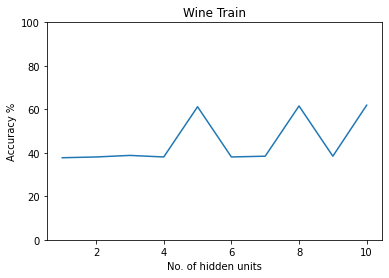

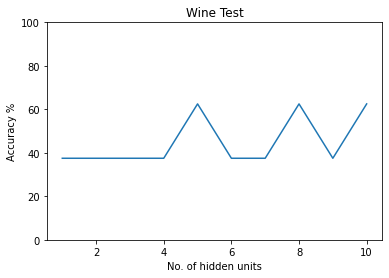

In [ ]:
# Plot the accuracy of different number of hidden units
plot_hidden_units(wine_train_acc, 'Wine Train')
plot_hidden_units(wine_test_acc, 'Wine Test')

In [ ]:
# Get the best number of hidden units
wine_best_n = max(wine_test_acc, key=wine_test_acc.get)
wine_best_n

5

### Summary table

In [ ]:
df_summary = pd.DataFrame()
df_summary['dataset'] = [data1, data2, data3, data4]
df_summary['best_n_hidden'] = [bc_best_n, diabetes_best_n, iris_best_n, wine_best_n]
df_summary['train_accuracy%'] = [bc_train_acc[bc_best_n], diabetes_train_acc[diabetes_best_n], iris_train_acc[iris_best_n], wine_train_acc[wine_best_n]]
df_summary['test_accuracy%'] = [bc_test_acc[bc_best_n], diabetes_test_acc[diabetes_best_n], iris_test_acc[iris_best_n], wine_test_acc[wine_best_n]]
df_summary['test_AUC_score'] = [bc_test_AUC[bc_best_n], diabetes_test_AUC[diabetes_best_n], iris_test_AUC[iris_best_n], wine_test_AUC[wine_best_n]]
df_summary['accuracy score'] = [bc_acc_score[bc_best_n], diabetes_acc_score[diabetes_best_n], iris_acc_score[iris_best_n], wine_acc_score[wine_best_n]]
df_summary['train_time'] = [bc_time[bc_best_n], diabetes_time[diabetes_best_n], iris_time[iris_best_n], wine_time[wine_best_n]]
df_summary

,dataset,best_n_hidden,train_accuracy%,test_accuracy%,test_AUC_score,accuracy score,train_time
0,breast-cancer,1,96.565657,97.142857,0.996922,0.970588,4.351020
1,diabetes,1,65.600000,64.903846,0.707819,0.647059,0.858900
2,iris,7,100.000000,100.000000,1.000000,1.000000,0.385917
3,wine,5,61.190476,62.500000,0.772727,0.611111,0.085353
